In [4]:
# pip install matplotlib

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from scipy.stats import linregress, pearsonr

# Read in data 

In [1]:
# [0.5 * (1 + 2*i + np.sqrt(1 + 8*i*i)) for i in range(100)]

In [25]:
dir = "/Users/rickiheicklen/Development/Github/scholars-and-sommeliers/"
df_orig = pd.read_csv(dir + "data.csv")
df_sources = df_orig[[x for x in df_orig.columns if 'Source' in x or 'Person' in x]]
df_wines = df_orig[[x for x in df_orig.columns if 'Wine' in x or 'Person' in x]]

In [26]:
# Sources:
# Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

df_sources = df_sources.rename(columns={'Source 1': 'Abarbanel', 
                   'Source 2': 'Bartenura',
                   'Source 3': 'Alfasi',
                   'Source 4': 'Sforno',
                   'Source 5': 'Rashi',
                   'Source 6': 'Schwartz'})

# Wines: 
# Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

df_wines = df_wines.rename(columns={'Wine A': 'Alfasi', 
                   'Wine B': 'Abarbanel',
                   'Wine C': 'Bartenura',
                   'Wine D': 'Rashi',
                   'Wine E': 'Sforno',
                   'Wine F': 'Schwartz'
                   })
                

In [27]:
df_sources_long = df_sources.melt(id_vars=["Person"], var_name="Rishon", value_name="Source")
df_wines_long = df_wines.melt(id_vars=["Person"], var_name="Rishon", value_name="Wine")

In [28]:
df = pd.merge(df_sources_long, df_wines_long, on=['Person', 'Rishon'])

In [29]:
# Select the columns to impute
numeric_cols = ['Source', 'Wine']
# Select the numerical columns
# numeric_cols = df.select_dtypes(include='number').columns

name_cols = ['Person','Rishon']
# Group the data by the 'group' column
groups = df.groupby('Person')

In [30]:
# Set which variable to color the points by (either Person or Rishon)
factor = "Rishon"

In [31]:
# df_imputed = df[df['Person'] != "Chana Fisch"]
df_imputed = pd.concat([group[group.columns[~group.columns.isin(numeric_cols)]].assign(**{col: imputer.fit_transform(group[[col]]) for col in numeric_cols}) for _, group in groups])

Text(0.5, 1.0, 'Scholars and Sommeliers: Rishon Quality Plot')

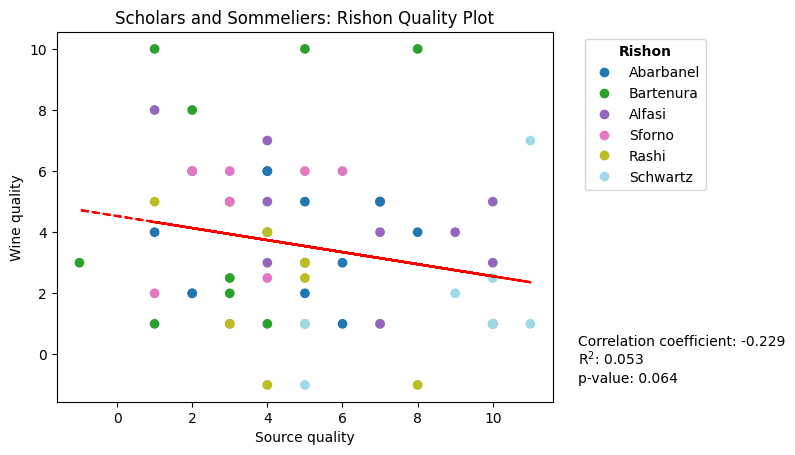

In [32]:
# Make color map and labels
colors, color_labels = pd.factorize(df_imputed[factor])
color_labels = color_labels.tolist()
color_map = cm.get_cmap('tab20')

# Fit a linear regression model
x = df_imputed['Source']
y = df_imputed['Wine']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the correlation coefficient
r_corr = pearsonr(x, y)[0]

# Calculate the R squared value
r_squared = r_value ** 2

# Create the scatterplot
scatter = plt.scatter(x, y, c=colors, cmap=color_map, label="Data")

# Plot the regression
plt.plot(x, intercept + slope * x, 'r--')

# Add the correlation coefficient and R squared value to the plot
plt.text(1.05, 0.15, f'Correlation coefficient: {r_corr:.3f}', transform=plt.gca().transAxes)
plt.text(1.05, 0.1, f'R$^2$: {r_squared:.3f}', transform=plt.gca().transAxes)
plt.text(1.05, 0.05, f'p-value: {p_value:.3f}', transform=plt.gca().transAxes)


# Add the legend
handles, _ = scatter.legend_elements()
legend = plt.legend(handles=handles, labels=color_labels, bbox_to_anchor=(1.05, 1), title=factor)
legend.get_title().set_weight('bold')

# Add axes labels
plt.xlabel('Source quality')
plt.ylabel('Wine quality')

# Add a title
plt.title('Scholars and Sommeliers: Rishon Quality Plot')

In [33]:
p_value

0.06400223490683937

# Everything below this is scrap for now

In [13]:
### Scrap from trying to use SimpleImputer ###

# Create a SimpleImputer to impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
# [group.columns[~group.columns.isin(numeric_cols)] for _, group in groups]
for a, group in groups:
    print(group) 


           Person     Rishon  Source  Wine
3   Avital Morris  Abarbanel       8   4.0
14  Avital Morris  Bartenura       4   4.0
25  Avital Morris     Alfasi       4   5.0
36  Avital Morris     Sforno       3   1.0
47  Avital Morris      Rashi      10   1.0
58  Avital Morris   Schwartz       9   2.0
         Person     Rishon  Source  Wine
4   Chana Fisch  Abarbanel       5   2.0
15  Chana Fisch  Bartenura       3   NaN
26  Chana Fisch     Alfasi      10   3.0
37  Chana Fisch     Sforno       4   NaN
48  Chana Fisch      Rashi       5   NaN
59  Chana Fisch   Schwartz      10   NaN
                   Person     Rishon  Source  Wine
2   Daniel Peled-Schwartz  Abarbanel       5   5.0
13  Daniel Peled-Schwartz  Bartenura      -1   3.0
24  Daniel Peled-Schwartz     Alfasi      10   5.0
35  Daniel Peled-Schwartz     Sforno       3   6.0
46  Daniel Peled-Schwartz      Rashi       7   1.0
57  Daniel Peled-Schwartz   Schwartz       5  -1.0
                    Person     Rishon  Source  Wine
6  

In [15]:
[group[group.columns[~group.columns.isin(numeric_cols)]] for _, group in groups]
for a, group in groups:
    print(group) 
    for col in numeric_cols:
        print(col)
        print(imputer)
        print(group[col])
        # imputer.fit_transform(group[col].reshape(-1,1))


           Person     Rishon  Source  Wine
3   Avital Morris  Abarbanel       8   4.0
14  Avital Morris  Bartenura       4   4.0
25  Avital Morris     Alfasi       4   5.0
36  Avital Morris     Sforno       3   1.0
47  Avital Morris      Rashi      10   1.0
58  Avital Morris   Schwartz       9   2.0
Source
SimpleImputer()
3      8
14     4
25     4
36     3
47    10
58     9
Name: Source, dtype: int64
Wine
SimpleImputer()
3     4.0
14    4.0
25    5.0
36    1.0
47    1.0
58    2.0
Name: Wine, dtype: float64
         Person     Rishon  Source  Wine
4   Chana Fisch  Abarbanel       5   2.0
15  Chana Fisch  Bartenura       3   NaN
26  Chana Fisch     Alfasi      10   3.0
37  Chana Fisch     Sforno       4   NaN
48  Chana Fisch      Rashi       5   NaN
59  Chana Fisch   Schwartz      10   NaN
Source
SimpleImputer()
4      5
15     3
26    10
37     4
48     5
59    10
Name: Source, dtype: int64
Wine
SimpleImputer()
4     2.0
15    NaN
26    3.0
37    NaN
48    NaN
59    NaN
Name: Wine, dty

In [17]:
[group[group.columns[~group.columns.isin(numeric_cols)]] for _, group in groups]


[           Person     Rishon
 3   Avital Morris  Abarbanel
 14  Avital Morris  Bartenura
 25  Avital Morris     Alfasi
 36  Avital Morris     Sforno
 47  Avital Morris      Rashi
 58  Avital Morris   Schwartz,
          Person     Rishon
 4   Chana Fisch  Abarbanel
 15  Chana Fisch  Bartenura
 26  Chana Fisch     Alfasi
 37  Chana Fisch     Sforno
 48  Chana Fisch      Rashi
 59  Chana Fisch   Schwartz,
                    Person     Rishon
 2   Daniel Peled-Schwartz  Abarbanel
 13  Daniel Peled-Schwartz  Bartenura
 24  Daniel Peled-Schwartz     Alfasi
 35  Daniel Peled-Schwartz     Sforno
 46  Daniel Peled-Schwartz      Rashi
 57  Daniel Peled-Schwartz   Schwartz,
                     Person     Rishon
 6   Jasmine Peled-Schwartz  Abarbanel
 17  Jasmine Peled-Schwartz  Bartenura
 28  Jasmine Peled-Schwartz     Alfasi
 39  Jasmine Peled-Schwartz     Sforno
 50  Jasmine Peled-Schwartz      Rashi
 61  Jasmine Peled-Schwartz   Schwartz,
            Person     Rishon
 5   Jen Greenberg  A

In [18]:
mean_values = [group[col]]


array([[1., 2., 3., 3.]])

In [18]:
from sklearn.impute import SimpleImputer
import numpy as np

# Create a 2D array with some missing values
X = np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]])

# Create a SimpleImputer instance with strategy='mean' and fit_transform the data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Print the original and imputed data
print("Original data:\n", X)
print("Imputed data:\n", X_imputed)

# imputer.fit_transform(np.array([[1,2,3,np.nan,3]])) #.toarray())

Original data:
 [[ 1.  2. nan]
 [ 4. nan  6.]
 [ 7.  8.  9.]]
Imputed data:
 [[1.  2.  7.5]
 [4.  5.  6. ]
 [7.  8.  9. ]]


In [4]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])

X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(imp_mean.transform(X))


[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


In [19]:
from sklearn.impute import SimpleImputer
import numpy as np

# Create a 2D array with some missing values
X = np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]])

# Create a SimpleImputer instance with strategy='mean'
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the data
imputer.fit(X)

# Transform the data by filling in the missing values with the mean
X_imputed = imputer.transform(X)

# Print the original and imputed data
print("Original data:\n", X)
print("Imputed data:\n", X_imputed)

Original data:
 [[ 1.  2. nan]
 [ 4. nan  6.]
 [ 7.  8.  9.]]
Imputed data:
 [[1.  2.  7.5]
 [4.  5.  6. ]
 [7.  8.  9. ]]


In [20]:
imputer.fit_transform([[1,2,3,np.nan,3]]) #.toarray())


array([[1., 2., 3., 3.]])

In [21]:
df_imputed = pd.concat([group[group.columns[~group.columns.isin(numeric_cols)]].assign(**{col: imputer.fit_transform(group[[col]]) for col in numeric_cols}) for _, group in groups])

In [23]:
df_imputed.head(60)

,Person,Rishon,Source,Wine
3,Avital Morris,Abarbanel,8.0,4.0
14,Avital Morris,Bartenura,4.0,4.0
25,Avital Morris,Alfasi,4.0,5.0
36,Avital Morris,Sforno,3.0,1.0
47,Avital Morris,Rashi,10.0,1.0
58,Avital Morris,Schwartz,9.0,2.0
4,Chana Fisch,Abarbanel,5.0,2.0
15,Chana Fisch,Bartenura,3.0,2.5
26,Chana Fisch,Alfasi,10.0,3.0
37,Chana Fisch,Sforno,4.0,2.5


In [ ]:
# Some code we are no longer using:
# 
# # # Create the scatter plot
# scatter = plt.scatter(df['score_source'], df['score_wine'], c=df['rishon_encoded'], cmap="viridis")

# # Add the color bar
# colorbar = plt.colorbar(scatter, label="Person")

# # Set the tick marks and labels on the color bar
# colorbar.set_ticks(range(len(person_labels)))
# colorbar.set_ticklabels(person_labels)


# plt.legend(handles=df["person_encoded"], labels=person_labels)

# # Add the color bar
# colorbar = plt.colorbar(scatter, cmap=color_map, label="Person",  extendfrac="auto", spacing="uniform", boundaries)
 
# # Set the tick marks and labels on the color bar
# colorbar.set_ticks(range(len(person_labels)))
# colorbar.set_ticklabels(person_labels)

In [ ]:
df = pd.read_csv("/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv")
df_sources = df_orig[[x for x in df_orig.columns if 'Source' in x or 'Person' in x]]
df_wines = df_orig[[x for x in df_orig.columns if 'Wine' in x or 'Person' in x]]
df_sources['Type'] = "Source"
df_wines['Type'] = "Wine"

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv'

In [ ]:
# Wines:
# Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

# Wines: 
# Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

df_orig.rename(columns={'Source 1': 'Abarbanel (Source)', 
                   'Source 2': 'Bartenura (Source)',
                   'Source 3': 'Alfasi (Source)',
                   'Source 4': 'Sforno (Source)',
                   'Source 5': 'Rashi (Source)',
                   'Source 6': 'Schwartz (Source)',
                   'Wine A': 'Alfasi (Wine)', 
                   'Wine B': 'Abarbanel (Wine)',
                   'Wine C': 'Bartenura (Wine)',
                   'Wine D': 'Rashi (Wine)',
                   'Wine E': 'Sforno (Wine)',
                   'Wine F': 'Schwartz (Wine)'
                   },
                   inplace=True)

In [ ]:
df_orig
df.melt(id_vars=["Person", "Type"], var_name="Rishon", value_name="score").head(60)

KeyError: "The following 'id_vars' are not present in the DataFrame: ['Type']"

In [ ]:
df_sources_long = df_sources.melt(id_vars=["Person", "Type"], var_name="Rishon", value_name="score")
df_wines_long = df_wines.melt(id_vars=["Person", "Type"], var_name="Rishon", value_name="score")

In [ ]:
pd.merge(df_sources_long, df_wines_long, on=['Person', 'Rishon'], suffixes=('_source', '_wine'))

,Person,Rishon,Source,Wine
0,Ricki Heicklen,Abarbanel,4.0,6.0
1,Joe Blumberg,Abarbanel,4.0,6.0
2,Daniel Peled-Schwartz,Abarbanel,5.0,5.0
3,Avital Morris,Abarbanel,8.0,4.0
4,Chana Fisch,Abarbanel,5.0,2.0
...,...,...,...,...
61,Jasmine Peled-Schwartz,Schwartz,10.0,1.0
62,Ronit Morris,Schwartz,10.0,1.0
63,Susan Palefsky,Schwartz,5.0,1.0
64,Tadhg Cleary,Schwartz,10.0,1.0


In [ ]:
df.melt(id_vars=["Person", "Type"], var_name="Rishon", value_name="score").head(60)

KeyError: "The following 'id_vars' are not present in the DataFrame: ['Type']"

In [ ]:
df = pd.read_csv("/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv")
df_sources = df[[x for x in df.columns if 'Source' in x or 'Person' in x]]
df_wines = df[[x for x in df.columns if 'Wine' in x or 'Person' in x]]
df_sources['Type'] = "Source"
df_wines['Type'] = "Wine"

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv'

In [ ]:
# Sources:
# Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

df_sources = df_sources.rename(columns={'Source 1': 'Abarbanel', 
                   'Source 2': 'Bartenura',
                   'Source 3': 'Alfasi',
                   'Source 4': 'Sforno',
                   'Source 5': 'Rashi',
                   'Source 6': 'Schwartz'})

In [ ]:
# Wines: 
# Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

df_wines = df_wines.rename(columns={'Wine A': 'Alfasi', 
                   'Wine B': 'Abarbanel',
                   'Wine C': 'Bartenura',
                   'Wine D': 'Rashi',
                   'Wine E': 'Sforno',
                   'Wine F': 'Schwartz'
                   })
                

In [ ]:
df = pd.concat([df_sources, df_wines])

In [ ]:
# def sources_and_wines(group):
#     sources = group[sources].values.tolist()
#     wines = group[wines].values.tolist()
#     return pd.Series({"Sources": sources, "Wines": wines})

# df_new = df.groupby("Person").apply(sources_and_wines).reset_index()

In [ ]:
# # Wines:
# # Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

# # Wines: 
# # Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

# df.rename(columns={'Source 1': 'Abarbanel (Source)', 
#                    'Source 2': 'Bartenura (Source)',
#                    'Source 3': 'Alfasi (Source)',
#                    'Source 4': 'Sforno (Source)',
#                    'Source 5': 'Rashi (Source)',
#                    'Source 6': 'Schwartz (Source)',
#                    'Wine A': 'Alfasi (Wine)', 
#                    'Wine B': 'Abarbanel (Wine)',
#                    'Wine C': 'Bartenura (Wine)',
#                    'Wine D': 'Rashi (Wine)',
#                    'Wine E': 'Sforno (Wine)',
#                    'Wine F': 'Schwartz (Wine)'
#                    },
#                    inplace=True)

In [ ]:
df

,Person,Abarbanel,Bartenura,Alfasi,Sforno,Rashi,Schwartz
0,Ricki Heicklen,4,8.0,9,6.0,1.0,11.0
1,Joe Blumberg,4,4.0,7,7.0,8.0,11.0
2,Daniel Peled-Schwartz,5,-1.0,10,3.0,7.0,5.0
3,Avital Morris,8,4.0,4,3.0,10.0,9.0
4,Chana Fisch,5,3.0,10,4.0,5.0,10.0
5,Jen Greenberg,1,1.0,1,1.0,5.0,10.0
6,Jasmine Peled-Schwartz,2,5.0,5,5.0,4.0,10.0
7,Ronit Morris,6,1.0,7,2.0,5.0,10.0
8,Susan Palefsky,2,3.0,4,3.0,4.0,5.0
9,Tadhg Cleary,7,2.0,4,10.0,5.0,10.0


### scrap from ChatGPT

In [ ]:
import pandas as pd

data = {
    'Student': ['Alice', 'Bob', 'Charlie'],
        'Color': ['red', 'yellow', 'blue'],
    'Study Hours': [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9, 10]],
    'Test Scores': [[10, 20, 30, 40], [50, 60, 70], [80, 90, 100, 110]]
}

df = pd.DataFrame(data)
df

,Student,Color,Study Hours,Test Scores
0,Alice,red,"[0, 1, 2, 3]","[10, 20, 30, 40]"
1,Bob,yellow,"[4, 5, 6]","[50, 60, 70]"
2,Charlie,blue,"[7, 8, 9, 10]","[80, 90, 100, 110]"


In [ ]:

# Flatten the 'Study Hours' and 'Test Scores' columns
df['Study Hours'] = df['Study Hours'].apply(lambda x: x[0])
df['Test Scores'] = df['Test Scores'].apply(lambda x: x[0])

# Create the scatter plot
# plt.scatter(df['Study Hours'], df['Test Scores'], c=df['Student'])

TypeError: 'int' object is not subscriptable

ValueError: setting an array element with a sequence.

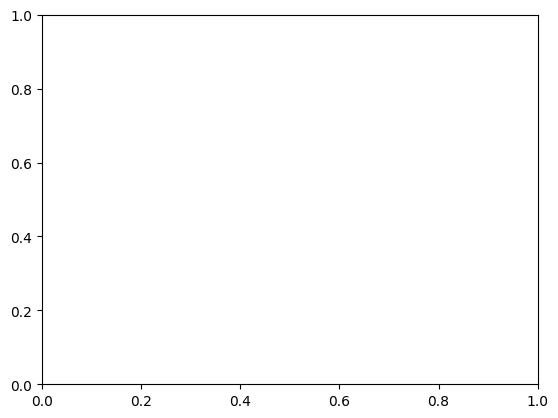

In [ ]:
colors = ['red', 'blue', 'green']

# Create the scatter plot
plt.scatter(df['Study Hours'], df['Test Scores'], c=colors)


In [ ]:
## Attempt at graphing rishonim

## Attempt at graphing rishonim

In [ ]:
df

,Student,Color,Study Hours,Test Scores
0,Alice,red,0,10
1,Bob,yellow,4,50
2,Charlie,blue,7,80


In [ ]:
data = {
    'Alice': [[0, 1, 2, 3], [10, 20, 30, 40]],
    'Bob': [[4, 5, 6], [50, 60, 70]],
    'Charlie': [[7, 8, 9, 10], [80, 90, 100, 110]]
}

In [ ]:
data

{'Alice': [[0, 1, 2, 3], [10, 20, 30, 40]],
 'Bob': [[4, 5, 6], [50, 60, 70]],
 'Charlie': [[7, 8, 9, 10], [80, 90, 100, 110]]}

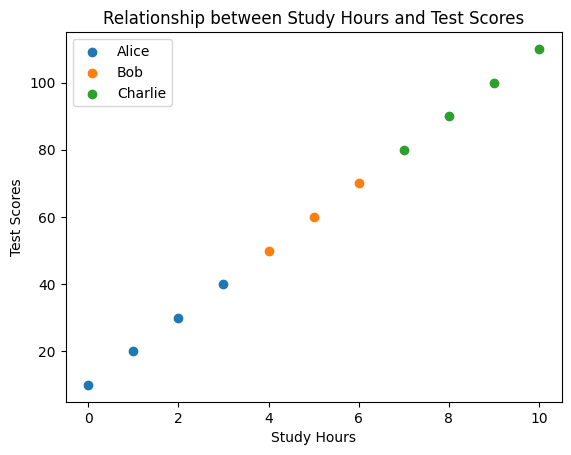

In [ ]:
# Loop through the data and plot each student's data
for student, (study_hours, test_scores) in data.items():
    plt.scatter(study_hours, test_scores, label=student)

# Add labels and title
plt.xlabel('Study Hours')
plt.ylabel('Test Scores')
plt.title('Relationship between Study Hours and Test Scores')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Loop through the data and plot each student's data
for student, (study_hours, test_scores) in data.items():
    plt.scatter(study_hours, test_scores, label=student)

# Add labels and title
plt.xlabel('Study Hours')
plt.ylabel('Test Scores')
plt.title('Relationship between Study Hours and Test Scores')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
for index, row in df.iterrows():
    plt.scatter(Source)
    print(row['Person'], row['Abarbanel (Source)'])


Ricki Heicklen 4
Joe Blumberg 4
Daniel Peled-Schwartz 5
Avital Morris 8
Chana Fisch 5
Jen Greenberg 1
Jasmine Peled-Schwartz 2
Ronit Morris 6
Susan Palefsky 2
Tadhg Cleary 7
Shalhevet Schwartz 6


In [ ]:
df = df.assign(Sources=lambda x: (x['Abarbanel (Source)'], x['Bartenura (Source)']))

KeyError: 'Abarbanel (Source)'

In [ ]:
def sources_and_wines(group):
    sources = group[sources].values.tolist()
    wines = group[wines].values.tolist()
    return pd.Series({"sources": sources, "wines": wines})

df_new = df.groupby("Person").apply(scores_and_dates).reset_index()

NameError: name 'scores_and_dates' is not defined

In [ ]:
df.drop(tyoe)

NameError: name 'tyoe' is not defined